In [2]:
import dill as pkl
from torch.utils.data import Dataset, DataLoader
from datasets import cropImage
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
import torch

# Notebook to create predictions for the challenge

It uses a pickled testset and an already trained model to make predictions.
The predictions are then packaged for submission.

In [40]:
testSetPath = 'example_testset.pkl'
modelPath = 'best_model.pt'

In [41]:
model = torch.load(modelPath)

In [42]:
challengeSet = CroppedOutImageDataSet(testSetPath)

In [43]:
predictions = []
for i in range(len(challengeSet)):
    inputs, targets, ids, mean, std, crops = challengeSet.__getitem__(i)

    cropped_image = inputs[0].numpy()
    inputs = torch.unsqueeze(inputs,0).to('cuda')
    prediction = np.squeeze(model(inputs).cpu().detach().numpy())
    top, bottom, left, right = crops
    cropped_prediction = prediction[top:bottom+1,left:right+1]
    cropped_prediction *= std
    cropped_prediction += mean
    cropped_prediction = np.array(cropped_prediction, dtype=np.uint8)
    predictions.append(cropped_prediction)

In [44]:
len(predictions)

500

In [45]:
pkl_out = open('pred_exampels.pkl','wb')
pkl.dump(predictions, pkl_out)
pkl_out.close()

In [46]:
from scoring import scoring
scoring('pred_exampels.pkl','example_targets.pkl')

1041.529758968481

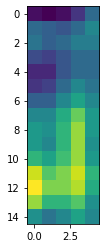

In [155]:
plt.figure()
plt.imshow(cropped_prediction)

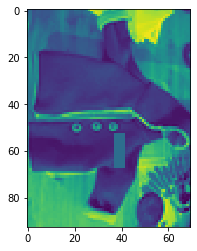

In [135]:
plt.figure()
plt.imshow(cropped_image)

In [3]:
class CroppedOutImageDataSet(Dataset):
    def __init__(self, pathToPkl):
      self.pklPath = pathToPkl
      with open(testSetPath,'rb') as tsp:
            testSet = pkl.load(tsp)
      self.images = testSet['images']
      self.crop_sizes = testSet['crop_sizes']
      self.crop_centers = testSet['crop_centers'] 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, id):
        image_data = np.array(self.images[id], dtype=np.float32)
        height, width = image_data.shape

        # setting some random crops
        top = self.crop_centers[id][0] - int(self.crop_sizes[id][0]/2)
        bottom = self.crop_centers[id][0] + int(self.crop_sizes[id][0]/2)
        left = self.crop_centers[id][1] - int(self.crop_sizes[id][1]/2)
        right = self.crop_centers[id][1] + int(self.crop_sizes[id][1]/2)

        cropped_image, crop_array, target_array = cropImage(image_data, top, bottom, left, right)

        temp = np.where(np.array(crop_array, dtype=bool), np.NaN, image_data).flatten()
        temp = np.array([x for x in temp if not np.isnan(x)])
        mean = temp.mean()
        std = temp.std()
        image_data[:] -= mean
        image_data[:] /= std

        cropped_image, crop_array, target_array = cropImage(image_data, top, bottom, left, right)

        # constructing the image we want to input to the model
        inputs = np.zeros(shape = (*cropped_image.shape, 4), dtype=cropped_image.dtype)
        inputs[..., 0] = cropped_image
        inputs[..., 1] = crop_array
        inputs[..., 2] = np.tile(np.linspace(start=-1, stop=1, num=width),reps=[height,1])
        inputs[..., 3] = np.tile(np.expand_dims(np.linspace(start=-1, stop=1, num=height),1),reps=[1,width])

        return TF.to_tensor(inputs), TF.to_tensor(target_array), id, mean, std, (top, bottom, left, right)

In [152]:
testSet['crop_sizes'][142]

(15, 5)

In [168]:
with open('pred_11702640.pkl','rb') as tsp:
            testpred = pkl.load(tsp)

In [169]:
testpred

2, 122],
        [118, 118, 118, 118, 120, 121, 120],
        [116, 117, 117, 117, 119, 120, 119],
        [115, 116, 117, 117, 119, 120, 120],
        [115, 116, 117, 117, 119, 121, 120],
        [115, 116, 117, 117, 119, 122, 121],
        [115, 116, 117, 118, 119, 121, 121]], dtype=uint8),
 array([[ 99, 101, 103, 105, 106, 105, 105, 108, 111, 113, 114, 116, 118,
         118, 120],
        [102, 104, 107, 108, 109, 109, 111, 114, 116, 117, 118, 122, 124,
         121, 123],
        [118, 120, 123, 126, 127, 125, 126, 127, 128, 128, 128, 131, 134,
         138, 144],
        [162, 158, 155, 153, 149, 144, 143, 141, 138, 134, 132, 135, 140,
         149, 159],
        [185, 179, 173, 167, 161, 154, 153, 149, 144, 138, 132, 130, 133,
         144, 158],
        [185, 180, 172, 164, 152, 143, 138, 136, 133, 129, 123, 119, 123,
         127, 133],
        [135, 138, 137, 133, 128, 124, 125, 127, 128, 127, 120, 113, 113,
         107,  99],
        [115, 121, 124, 123, 131, 143, 153, 158,